In [ ]:
from autots import AutoTS, load_daily
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# sample datasets can be used in either of the long or wide import shapes
long = False
df = load_daily(long=long)

model = AutoTS(
    forecast_length=21,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='auto',
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model = model.fit(
    df,
    date_col='datetime' if long else None,
    value_col='value' if long else None,
    id_col='series_id' if long else None,
)

prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric, series=model.df_wide_numeric.columns[0], start_date="2019-01-01")
# Print the details of the best model
print(model)

# point forecasts dataframe
forecasts_df = prediction.forecast
# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

# accuracy of all tried model results
model_results = model.results()
# and aggregated from cross validation
validation_results = model.results("validation")

In [72]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values
import numpy as np
import cx_Oracle
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

config = dotenv_values("../../../.env")

out_db_params = {
    'db_host': config["ORACLE_IP"],
    'db_name': config["ORACLE_DB"],
    'db_user': config["ORACLE_USER"],
    'db_password': config["ORACLE_PWD"],
    'db_port': config["ORACLE_PORT"]
}
print(config["LD_LIBRARY_PATH"])
cx_Oracle.init_oracle_client(lib_dir=config["LD_LIBRARY_PATH"])

/home/mfrancia/predict/intentional/libs/instantclient_21_1


ProgrammingError: Oracle Client library has already been initialized

In [73]:
engine = create_engine('oracle+cx_oracle://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'.format(**out_db_params))
query = "SELECT * FROM cimice_dt_time"
df = pd.read_sql(query, engine)
df

,timestamp,date,month,year,week,week_in_year
0,2022-06-06,06-JUN-22,2022-6,2022,23,2022-23
1,2021-05-03,03-MAY-21,2021-5,2021,18,2021-18
2,2020-05-11,11-MAY-20,2020-5,2020,20,2020-20
3,2022-09-12,12-SEP-22,2022-9,2022,37,2022-37
4,2021-03-22,22-MAR-21,2021-3,2021,12,2021-12
...,...,...,...,...,...,...
83,2021-09-13,13-SEP-21,2021-9,2021,37,2021-37
84,2022-06-20,20-JUN-22,2022-6,2022,25,2022-25
85,2021-08-16,16-AUG-21,2021-8,2021,33,2021-33
86,2022-09-26,26-SEP-22,2022-9,2022,39,2022-39


In [121]:
# Replace 'your_table' with the actual table name
query = "SELECT t.province, d.week_in_year, f.* FROM cimice_ft_captures f, cimice_dt_trap t, cimice_dt_time d where t.gid = f.gid and province='FC' and f.timestamp = d.timestamp"
df = pd.read_sql(query, engine)
df = df.drop(['gid'], axis=1)
print(df.columns)
df = df.groupby(['province', 'week_in_year']).mean().reset_index()
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index('timestamp', inplace=True)
# df.index = pd.DatetimeIndex(df.index).to_period('W')
df.index = pd.DatetimeIndex(df.index).to_period('D')
df

Index(['province', 'week_in_year', 'timestamp', 'adults', 'small_instars',
       'large_instars', 'temperature_avg', 'temperature_max',
       'temperature_min', 'humidity_avg', 'humidity_max', 'humidity_min',
       'precipitations_day', 'radiations_day', 'evapo_transpiration',
       'wind_direction_day', 'wind_speed_avg', 'wind_speed_max',
       'days_since_last_monitoring', 'degree_days', 'total_captures'],
      dtype='object')


,province,week_in_year,adults,small_instars,large_instars,temperature_avg,temperature_max,temperature_min,humidity_avg,humidity_max,humidity_min,precipitations_day,radiations_day,evapo_transpiration,wind_direction_day,wind_speed_avg,wind_speed_max,days_since_last_monitoring,degree_days,total_captures
timestamp,,,,,,,,,,,,,,,,,,,,
2020-05-04,FC,2020-19,7.333333,0.000000,0.000,18.046672,22.820002,11.883334,55.066667,75.666667,38.133333,0.400000,0.0,4.033333,166.239583,2.500000,5.033333,7.000000,37.166679,7.333333
2020-05-11,FC,2020-20,4.666667,0.000000,0.000,18.677779,23.750792,13.648415,61.333333,84.595238,40.047619,1.233332,0.0,4.171429,171.406250,2.242064,4.621429,6.666667,43.600006,4.666667
2020-05-18,FC,2020-21,1.396694,0.000000,0.000,19.139775,23.329419,14.530304,71.575577,89.572511,50.553211,2.572727,0.0,4.027128,208.640016,2.140837,3.973792,6.727273,46.890924,1.396694
2020-05-25,FC,2020-22,0.882507,0.000000,0.000,19.572337,24.293019,12.850260,51.810065,75.977273,33.898052,1.036364,0.0,4.652500,127.523133,2.670390,5.097598,6.727273,49.772724,0.882507
2020-06-01,FC,2020-23,1.993526,0.502392,0.000,19.196178,23.678029,14.138764,61.122655,84.268759,41.460137,22.218185,0.0,4.346393,156.649756,2.189015,4.259235,8.363636,58.500018,2.495919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-19,FC,2022-38,33.053571,0.678571,7.375,18.337949,24.744196,11.914284,64.678571,NaN,NaN,27.537504,NaN,3.294196,NaN,NaN,NaN,6.625000,40.425021,41.107143
2022-09-26,FC,2022-39,19.023129,0.061224,1.200,16.817752,22.052464,12.100965,71.903571,NaN,NaN,24.740000,NaN,2.573714,NaN,NaN,NaN,8.300000,38.240020,20.284354
2022-10-03,FC,2022-40,20.038095,0.100000,0.200,17.954465,23.378786,13.119963,74.731786,NaN,NaN,5.680000,NaN,2.509857,NaN,NaN,NaN,6.600000,38.110004,20.338095


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 86 entries, 2020-05-04 to 2022-10-17
Freq: D
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   province                    86 non-null     object 
 1   week_in_year                86 non-null     object 
 2   adults                      86 non-null     float64
 3   small_instars               86 non-null     float64
 4   large_instars               86 non-null     float64
 5   temperature_avg             86 non-null     float64
 6   temperature_max             86 non-null     float64
 7   temperature_min             86 non-null     float64
 8   humidity_avg                86 non-null     float64
 9   humidity_max                56 non-null     float64
 10  humidity_min                56 non-null     float64
 11  precipitations_day          86 non-null     float64
 12  radiations_day              56 non-null     float64
 13  evapo_trans

/home/mfrancia/predict/intentional/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -245.120
Date:                           Wed, 07 Feb 2024   AIC                            500.241
Time:                                   13:59:10   BIC                            511.411
Sample:                               05-04-2020   HQIC                           504.673
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9470      0.237     -3.996      0.000      -1.411      -0.483
ma.L1          0.9241      0.288      3.208      0.001       0.359       1.489
ar.S.L7        0.2008      0.178      1.126      0.260      -0.149       0.550
ma.S.L7       -0.9996     88.850     -0.011      0.991    -175.143     173.144
sigma2        57.9991   5146.425      0.011      0.991      -1e+04    1.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                73.04
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.94
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

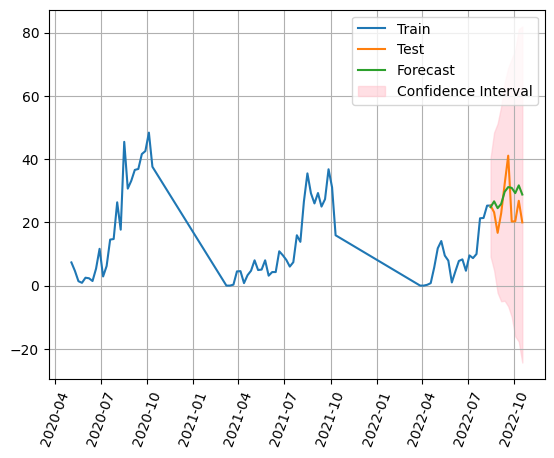

In [137]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def sarimax(df, c='total_captures', forecast_steps=10, seasonality=7, exog=[]):
    train = df[c][:-forecast_steps+1]
    test = df[c][-forecast_steps:]
    order = (1, 1, 1) # to tune 
    seasonal_order = (1, 1, 1, seasonality) # to tune
    if len(exog) == 0:
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    else:
        model = SARIMAX(endog=train, exog=df[exog][:-forecast_steps+1].to_numpy(), order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    if len(exog) == 0:
        fcst = results.get_forecast(steps=forecast_steps)
    else:
        fcst = results.get_forecast(steps=forecast_steps, exog=df[exog][-forecast_steps:])
        # fcst = results.get_prediction(start='2022-01-06', end='2022-01-09').predicted_mean 
    forecast = fcst.predicted_mean
    forecast.index = test.index
    plt.plot(train.index.to_timestamp(), train, label='Train')
    plt.plot(test.index.to_timestamp(), test, label='Test')
    plt.plot(forecast.index.to_timestamp(), forecast, label='Forecast')
    plt.fill_between(
        forecast.index.to_timestamp(),
        fcst.conf_int()[f'lower {c}'],
        fcst.conf_int()[f'upper {c}'],
        color='pink',
        alpha=0.5,
        label='Confidence Interval'
    )
    plt.grid()
    plt.legend()
    plt.xticks(rotation=70)
    summary = results.summary()
    return summary

sarimax(df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -230.530
Date:                           Wed, 07 Feb 2024   AIC                            477.059
Time:                                   13:59:11   BIC                            494.932
Sample:                               05-04-2020   HQIC                           484.150
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0800      0.200      5.390      0.000       0.687       1.473
x2             0.7856      0.409      1.922      0.055      -0.016       1.587
x3             0.7313      0.385      1.897      0.058      -0.024       1.487
ar.L1          0.1637      0.897      0.183      0.855      -1.594       1.922
ma.L1          0.0679      0.904      0.075      0.940      -1.704       1.840
ar.S.L7        0.0814      0.225      0.362      0.717      -0.359       0.521
ma.S.L7       -0.9992     57.768     -0.017      0.986    -114.222     112.224
sigma2        37.2279   2146.322      0.017      0.986   -4169.486    4243.942
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               174.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -1.60
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

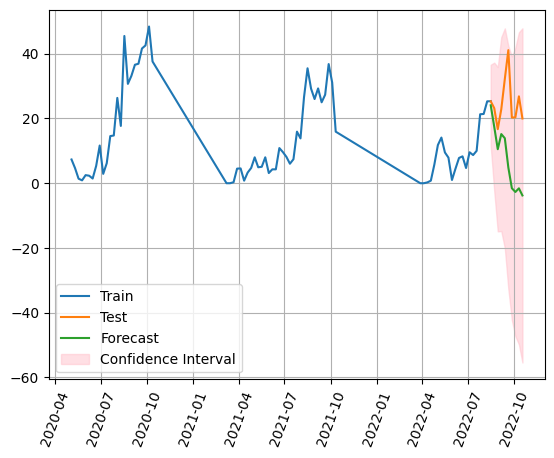

In [138]:
sarimax(df, exog=["small_instars", "large_instars", "temperature_avg"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -231.989
Date:                           Wed, 07 Feb 2024   AIC                            477.978
Time:                                   13:59:11   BIC                            493.616
Sample:                               05-04-2020   HQIC                           484.182
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1839      0.158      7.471      0.000       0.873       1.494
x2             1.4932      0.453      3.293      0.001       0.604       2.382
ar.L1         -0.5203      0.229     -2.274      0.023      -0.969      -0.072
ma.L1          0.8354      0.167      5.014      0.000       0.509       1.162
ar.S.L7        0.1382      0.183      0.756      0.450      -0.220       0.497
ma.S.L7       -0.9994     63.281     -0.016      0.987    -125.028     123.029
sigma2        39.2651   2479.570      0.016      0.987   -4820.604    4899.134
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                57.26
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -1.09
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

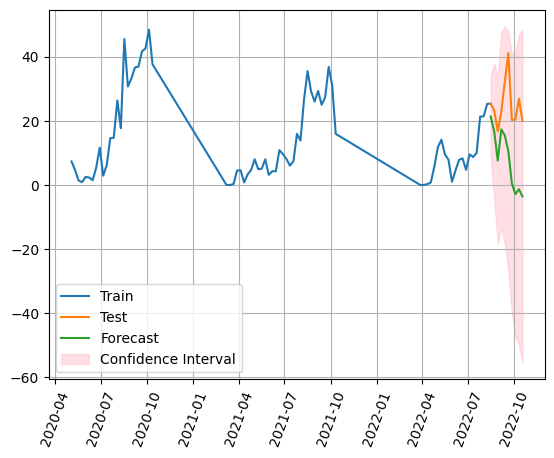

In [139]:
sarimax(df, exog=["small_instars", "large_instars"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -195.588
Date:                           Wed, 07 Feb 2024   AIC                            405.175
Time:                                   13:59:12   BIC                            420.814
Sample:                               05-04-2020   HQIC                           411.380
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8859      0.223      3.977      0.000       0.449       1.322
x2             0.9565      0.127      7.532      0.000       0.708       1.205
ar.L1         -0.5940      0.324     -1.831      0.067      -1.230       0.042
ma.L1          0.3949      0.409      0.964      0.335      -0.408       1.197
ar.S.L7       -0.0078      0.309     -0.025      0.980      -0.614       0.599
ma.S.L7       -0.8242      0.330     -2.498      0.012      -1.471      -0.178
sigma2        15.0988      3.153      4.788      0.000       8.918      21.279
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.79   Prob(JB):                         0.51
Heteroskedasticity (H):               0.20   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

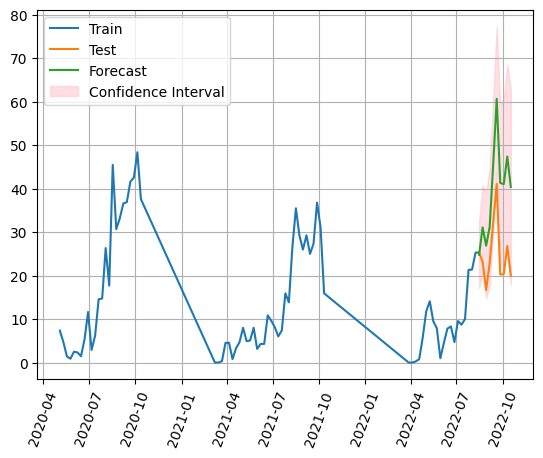

In [140]:
sarimax(df, exog=["large_instars", "adults"])

/home/mfrancia/predict/intentional/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -130.513
Date:                           Wed, 07 Feb 2024   AIC                            275.026
Time:                                   13:59:12   BIC                            290.665
Sample:                               05-04-2020   HQIC                           281.231
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9690      0.044     21.926      0.000       0.882       1.056
x2             0.9828      0.025     39.812      0.000       0.934       1.031
ar.L1         -0.4854      1.557     -0.312      0.755      -3.537       2.566
ma.L1          0.4120      1.677      0.246      0.806      -2.875       3.698
ar.S.L7       -0.0929      0.187     -0.498      0.619      -0.459       0.273
ma.S.L7       -0.9964     13.659     -0.073      0.942     -27.767      25.774
sigma2         1.9923     27.026      0.074      0.941     -50.978      54.963
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                65.83
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

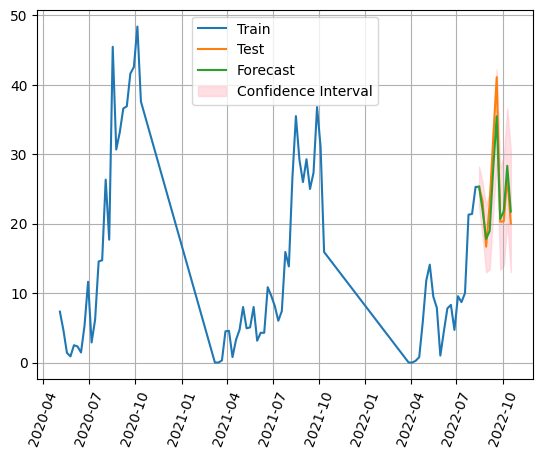

In [141]:
sarimax(df, exog=["small_instars", "adults"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 361.401
Date:                           Wed, 07 Feb 2024   AIC                           -706.802
Time:                                   13:59:13   BIC                           -688.929
Sample:                               05-04-2020   HQIC                          -699.711
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000   2.38e-07   4.21e+06      0.000       1.000       1.000
x2             1.0000   3.95e-07   2.53e+06      0.000       1.000       1.000
x3             1.0000   1.56e-07   6.39e+06      0.000       1.000       1.000
ar.L1         -0.2278   1.39e-12  -1.64e+11      0.000      -0.228      -0.228
ma.L1         -0.3207   3.58e-12  -8.96e+10      0.000      -0.321      -0.321
ar.S.L7       -0.3687   3.01e-12  -1.23e+11      0.000      -0.369      -0.369
ma.S.L7       -0.0015   3.01e-12  -4.88e+08      0.000      -0.001      -0.001
sigma2      4.435e-10    3.4e-10      1.303      0.192   -2.23e-10    1.11e-09
===================================================================================
Ljung-Box (L1) (Q):                  10.89   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.00   Prob(JB):                         0.61
Heteroskedasticity (H):               0.39   Skew:                            -0.14
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+26. Standard errors may be unstable.
"""

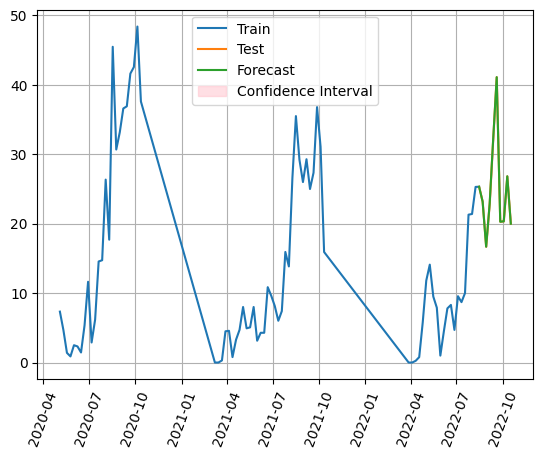

In [142]:
sarimax(df, exog=["small_instars", "large_instars", "adults"])
# tuning s automatically


/home/mfrancia/predict/intentional/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    total_captures   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 120.152
Date:                           Wed, 07 Feb 2024   AIC                           -220.304
Time:                                   13:59:13   BIC                           -197.963
Sample:                               05-04-2020   HQIC                          -211.441
                                    - 08-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000   1.49e-22   6.73e+21      0.000       1.000       1.000
x2             1.0000   5.67e-23   1.76e+22      0.000       1.000       1.000
x3             1.0000   4.49e-22   2.23e+21      0.000       1.000       1.000
x4          4.709e-15   1.77e-22   2.66e+07      0.000    4.71e-15    4.71e-15
x5          6.351e-15   1.88e-22   3.38e+07      0.000    6.35e-15    6.35e-15
ar.L1         -0.2557   1.43e-19  -1.79e+18      0.000      -0.256      -0.256
ma.L1          0.1953   1.45e-19   1.35e+18      0.000       0.195       0.195
ar.S.L7       -0.0802   1.11e-21  -7.23e+19      0.000      -0.080      -0.080
ma.S.L7       -0.4963   4.37e-20  -1.14e+19      0.000      -0.496      -0.496
sigma2          1e-10   2.52e-10      0.396      0.692   -3.95e-10    5.95e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1011.36
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.01e+57. Standard errors may be unstable.
"""

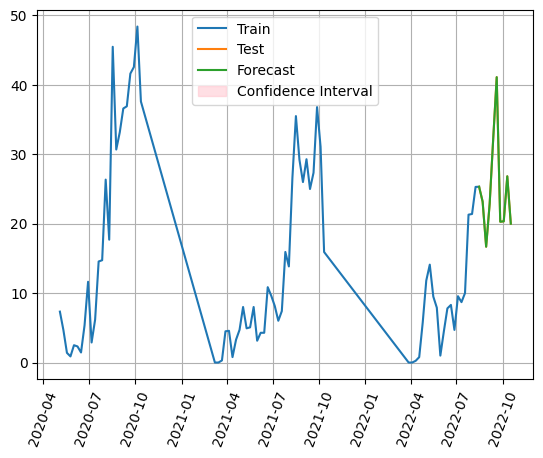

In [143]:
sarimax(df, exog=["small_instars", "large_instars", "adults", "temperature_avg", "temperature_min"])

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
rnd_state = 42
out_df = df
dt = df.reset_index()
dt["timestamp"] = dt['timestamp'].astype(int) / 10**9 
def forecast(df, model, endog="total_captures", exog=["total_captures", "adults", "small_instars", "large_instars"], forecast_steps=10):
    # should add lagged variables 
    train = df[list(set(exog+[endog]))][:-forecast_steps+1].astype(float)
    test  = df[list(set(exog+[endog]))][-forecast_steps+0:].astype(float)
    X_train, X_test, y_train, y_test = train[exog], test[exog], train[endog], test[endog]
    # X_train, X_test, y_train, y_test = train_test_split(df[exog].astype(float).to_numpy(), df[endog], test_size=0.20, random_state=12345, shuffle=False)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    plt.plot(out_df[:-forecast_steps+1].index.to_timestamp(), y_train, label='Train')
    plt.plot(out_df[-forecast_steps+0:].index.to_timestamp(), y_test, label='Test')
    plt.plot(out_df[-forecast_steps+0:].index.to_timestamp(), forecast, label='Forecast')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=70)
    return (model.best_params_, r2_score(list(y_test), list(forecast)))

({'min_samples_split': 6,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'max_depth': 10},
 0.6983821914099009)

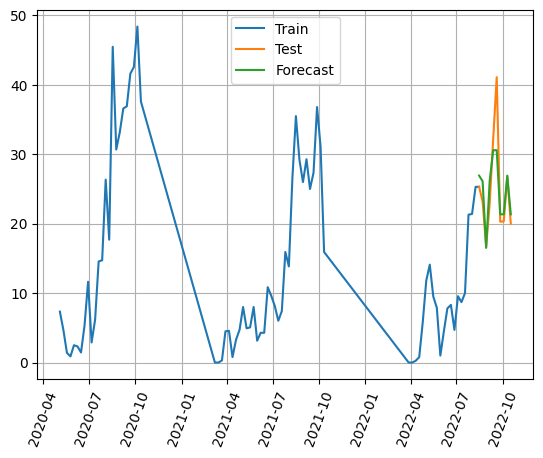

In [145]:
my_dt = RandomizedSearchCV(
        DecisionTreeRegressor(random_state=rnd_state),
        {
            'max_depth': [None] + list(np.arange(2, 20)),
            'min_samples_split': np.arange(2, 11),
            'min_samples_leaf': np.arange(1, 11),
            'max_features': ['sqrt', 'log2']
        },
        n_iter=100, scoring = 'r2', n_jobs = -1, random_state = rnd_state
    )

forecast(dt, my_dt)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95300D+00    |proj g|=  5.66733D-02

At iterate    5    f=  1.90625D+00    |proj g|=  4.00592D-02

At iterate   10    f=  1.89853D+00    |proj g|=  6.29685D-03

At iterate   15    f=  1.89807D+00    |proj g|=  7.77551D-04

At iterate   20    f=  1.89755D+00    |proj g|=  5.53421D-03

At iterate   25    f=  1.89746D+00    |proj g|=  5.22830D-04

At iterate   30    f=  1.89743D+00    |proj g|=  1.60725D-04

At iterate   35    f=  1.89742D+00    |proj g|=  1.53690D-04

At iterate   40    f=  1.89742D+00    |proj g|=  7.95417D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

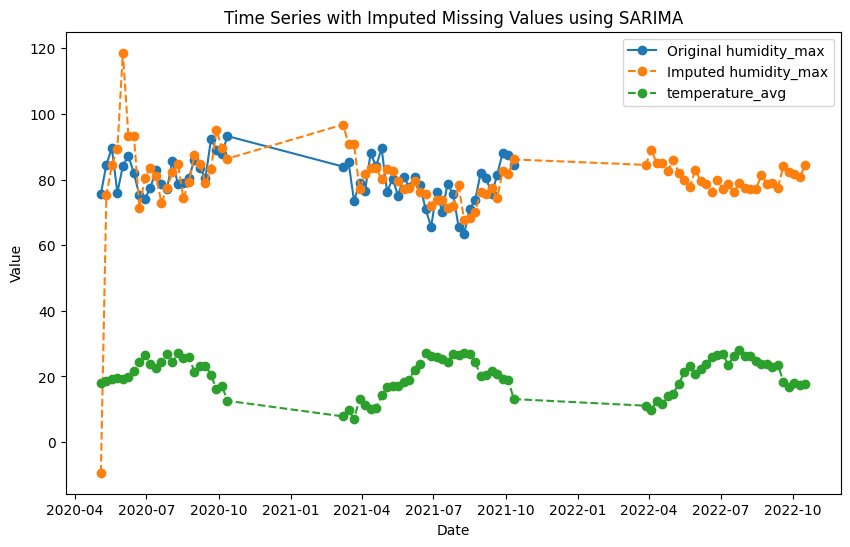

In [167]:
# Plot the original time series
plt.figure(figsize=(10, 6))
c = 'humidity_max'
plt.plot(df.index.to_timestamp(), df[c], marker='o', linestyle='-', label=f'Original {c}')
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 4)  # (P, D, Q, s)
model = SARIMAX(df[c], exog=df[["temperature_avg"]].to_numpy(), order=order, seasonal_order=seasonal_order)
results = model.fit()

predicted_values = results.get_prediction(start=df.index.min(), end=df.index.max()).predicted_mean

# Plot the imputed time series
plt.plot(predicted_values.index.to_timestamp(), predicted_values, marker='o', linestyle='--', label=f'Imputed {c}')
plt.plot(df.index.to_timestamp(), df["temperature_avg"], marker='o', linestyle='--', label=f'temperature_avg')
plt.title('Time Series with Imputed Missing Values using SARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47716D+00    |proj g|=  7.84233D-02

At iterate    5    f=  2.37308D+00    |proj g|=  2.73832D-02

At iterate   10    f=  2.32289D+00    |proj g|=  1.48556D-01

At iterate   15    f=  2.28816D+00    |proj g|=  7.79129D-03

At iterate   20    f=  2.28788D+00    |proj g|=  5.48649D-05

At iterate   25    f=  2.28787D+00    |proj g|=  5.64982D-04

At iterate   30    f=  2.28784D+00    |proj g|=  1.13090D-03

At iterate   35    f=  2.28783D+00    |proj g|=  1.54509D-04

At iterate   40    f=  2.28783D+00    |proj g|=  1.38159D-04

At iterate   45    f=  2.28783D+00    |proj g|=  7.79980D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

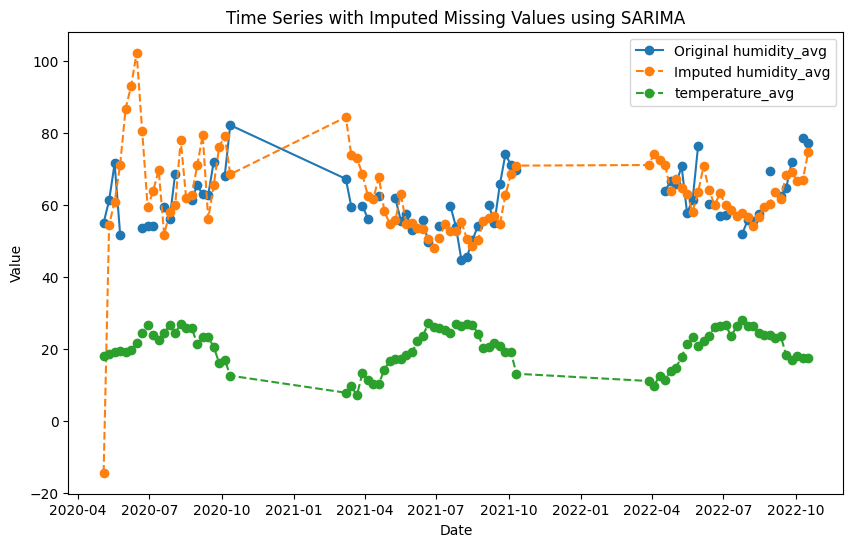

In [170]:
np.random.seed(42)

c = "humidity_avg"
mask = np.random.choice([True, False], df.shape[0], p=[0.2, 0.8])
df.loc[mask, c] = np.nan

# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(df.index.to_timestamp(), df[c], marker='o', linestyle='-', label=f'Original {c}')
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 4)  # (P, D, Q, s)
model = SARIMAX(df[c], exog=df[["temperature_avg"]].to_numpy(), order=order, seasonal_order=seasonal_order)
results = model.fit()

predicted_values = results.get_prediction(start=df.index.min(), end=df.index.max()).predicted_mean

# Plot the imputed time series
plt.plot(predicted_values.index.to_timestamp(), predicted_values, marker='o', linestyle='--', label=f'Imputed {c}')
plt.plot(df.index.to_timestamp(), df["temperature_avg"], marker='o', linestyle='--', label=f'temperature_avg')
plt.title('Time Series with Imputed Missing Values using SARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()